In [1]:
"""

f(R) gravity emulator: for fast generation of P_mg/P_lcdm


Requires the following installations:

1. gpflow
2. scipy
3. sklearn 
"""

##### Generic packages ###############
import numpy as np
import matplotlib.pylab as plt
import time
import glob
import os

import pickle
from sklearn.decomposition import PCA
import gpflow
import scipy.signal


####### PLOTTING SETTINGS #####
from itertools import cycle
import matplotlib.ticker as ticker
from matplotlib import gridspec


# plt.rc('text', usetex=True)  # Slower
plt.rc('axes',labelsize= 10)
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')


########## R imports ############
# RcppCNPy = importr('RcppCNPy')
# RcppCNPy.chooseCRANmirror(ind=1) # select the first mirror in the list
## There are other importr calls in PCA and GP functions


In [2]:
############################# PARAMETERS ##############################

# dataDir = "./Data/Fixedn/" ## Data folder
# modelDir = "./Models/Fixedn/" ## Data folder
# plotsDir = "./Plots/Fixedn/" ## Data folder

# dataDir = "./Data/Fixedn_val/" ## Data folder
# modelDir = "./Models/Fixedn_val/" ## Data folder
# plotsDir = "./Plots/Fixedn_val/" ## Data folder


dataDir = "./Data/Fixedn_val_latest/" ## Data folder
modelDir = "./Models/Fixedn_val_latest/" ## Data folder
plotsDir = "./Plots/Fixedn_val_latest/" ## Data folder


nRankMax = [2, 4, 8, 12, 16, 32][5]  ## Number of basis vectors in truncated PCA
## Increasing nRankMax will increase emulation precision (asymptotically), but reduce the speed
# del_idx = []  ## Random holdouts (not used in training, reserved for validation) 
del_idx = [50, 51, 52, 53, 54]  ## Random holdouts (not used in training, reserved for validation) 
# DONOT use these: (array([22, 15, 19, 20, 35]), array([27, 34, 30, 29, 14])) -- edge cases
snap_ID = 97


############################# PARAMETERS ##############################


fileIn = dataDir + 'ratiosbinsnew_' + str(snap_ID) + '.txt'
# paramIn = dataDir + 'mg_log_val.design'
paramIn = dataDir + 'mg_log_val_2.design'



az = np.loadtxt(dataDir + 'timestepsCOLA.txt', skiprows=1) 
fileIn = dataDir + 'ratiosbins_' + str(snap_ID) + '.txt'
z_ID = az[snap_ID, 1]


fileIn = dataDir + 'ratiosbinsnew_' + str(snap_ID) + '.txt'

GPmodel = modelDir + 'nCorrLogfixedGP_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  ## Double and single quotes are necessary
PCAmodel = modelDir + 'nCorrLogfixedPCA_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  ## Double and single quotes are necessary

print(GPmodel)
################################# I/O #################################




./Models/Fixedn_val_latest/nCorrLogfixedGP_smooth_rank32snap97


In [3]:
loadFile = np.loadtxt(fileIn)
PmPl_all = loadFile[:, 1:].T
kvals = loadFile[:,0]

parameter_array_all = np.loadtxt(paramIn)
parameter_array_all[:, 3] = np.log10(parameter_array_all[:, 3])

parameter_array_unscaled = np.loadtxt(paramIn)
# parameter_array_unscaled[:, 3] = np.log10(parameter_array_unscaled[:, 3])

In [4]:
# loadFile = np.loadtxt(fileIn)
# PmPl_all = loadFile[:, 1:].T
# kvals = loadFile[:,0]


# parameter_array_all = np.loadtxt(paramIn)
# parameter_array_unscaled = np.loadtxt(paramIn)


############## rescaling ##############


def rescale01(f):
    return np.min(f), np.max(f), (f - np.min(f)) / (np.max(f) - np.min(f))


def scale01(fmin, fmax, f):
    return (f - fmin) / (fmax - fmin)
#     return f*(fmax - fmin) + fmin


lhd = np.zeros_like(parameter_array_all)
lhdmin = np.zeros_like(parameter_array_all[1])
lhdmax = np.zeros_like(parameter_array_all[1])

for i in range(parameter_array_all.shape[1]):
    lhdmin[i], lhdmax[i], lhd[:, i] = rescale01(parameter_array_all[:, i])
   

parameter_array_all = lhd

# _,_,PmPl_all = rescale01(loadFile[:, 1:].T)

############## rescaling ##############


## Removing hold-out test points
parameter_array = np.delete(parameter_array_all, del_idx, axis=0)
PmPl = np.delete(PmPl_all, del_idx, axis=0)

(array([72., 41., 25., 18., 13., 12.,  9.,  9.,  7.,  7.]),
 array([0.031215 , 0.3753391, 0.7194632, 1.0635873, 1.4077114, 1.7518355,
        2.0959596, 2.4400837, 2.7842078, 3.1283319, 3.472456 ]),
 <a list of 10 Patch objects>)

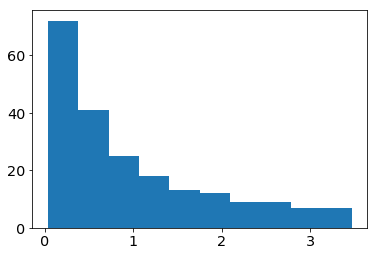

In [5]:
plt.hist(kvals)

In [6]:
lhdmin

array([ 0.12,  0.85,  0.7 , -8.  ,  0.  ])

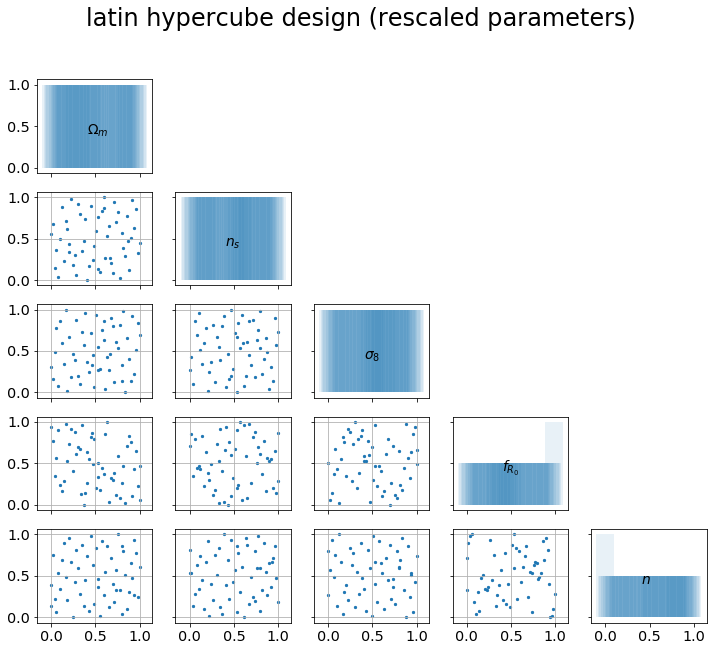

In [7]:
############################# Plot the input parameter distribution ##############################

allLabels = [r'${\Omega}_m$', r'$n_s$', r'${\sigma}_8$', r'$f_{R_0}$', r'$n$']

# def rescale01(f):
#     return (f - np.min(f)) / (np.max(f) - np.min(f))

# lhd = np.zeros_like(parameter_array_all)
# for i in range(parameter_array_all.shape[1]):
#     _, _, lhd[:, i] = rescale01(parameter_array_all[:, i])
    
def plot_params(lhd):
    f, a = plt.subplots(lhd.shape[1], lhd.shape[1], sharex=True, sharey=True, figsize=(12, 10) )
    plt.suptitle('latin hypercube design (rescaled parameters)', fontsize = 24)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.rcParams.update({'font.size': 8})

    for i in range(lhd.shape[1]):
        for j in range(i + 1):
            if (i != j):
                a[i, j].scatter(lhd[:, i], lhd[:, j], s=5)
                a[i, j].grid(True)
                
#             if (j > i):
                
                
            else:
                hist, bin_edges = np.histogram(lhd[:, i], density=True, bins=64)
                a[i, i].text(0.4, 0.4, allLabels[i], size = 'xx-large')

                a[i, i].bar(bin_edges[:-1], hist / hist.max(), width=0.2, alpha = 0.1)

    for i in range(lhd.shape[1]):
        for j in range(i + 1, lhd.shape[1]):

            plt.delaxes(a[i][j])
    plt.show()


plot_params(lhd)

In [8]:
########################### PCA ###################################
# set up pca compression
from sklearn.decomposition import PCA


def PCA_compress(x, nComp):
    # x is in shape (nCosmology, nbins)
    pca_model = PCA(n_components=nComp)
    principalComponents = pca_model.fit_transform(x)
    pca_bases = pca_model.components_

    print("original shape:   ", x.shape)
    print("transformed shape:", principalComponents.shape)
    print("bases shape:", pca_bases.shape)

    import pickle
    pickle.dump(pca_model, open(PCAmodel, 'wb'))

    return pca_model, np.array(principalComponents), np.array(pca_bases)


######################## GP FITTING ################################

## Build GP models
# This is evaluated only once for the file name. GP fitting is not required if the file exists.
  

def GPflow_fit(parameter_array, weights, fname= GPmodel):
    kern = gpflow.kernels.Matern52(input_dim = np.shape(parameter_array)[1], ARD=True)
#     m1 = GPy.models.GPRegression(parameter_array, weights, kernel=kern)
    m = gpflow.models.GPR(parameter_array, weights, kern=kern, mean_function=None)
#     print_summary(m)
    m.likelihood.variance.assign(0.01)
#     m.kern.lengthscales.assign([100, 100, 100, 100, 100])
#     m.kern.lengthscales.assign([1, 1, 1, 0.1, 0.1])

#     m.kern.lengthscales.assign([0.3, 0.1, 0.2, 0.3, 0.1])
    m.kern.lengthscales.assign([25, 65, 15 ,1, 1])


#     opt = gpflow.optimizers.Scipy()
    
    opt = gpflow.train.ScipyOptimizer()
    opt.minimize(m)
    m.as_pandas_table()
    
    from pathlib import Path

    print(f'GPR lengthscales =', m.kern.lengthscales.value)

    
    path = Path(GPmodel)
    if path.exists():
        path.unlink()
    
    saver = gpflow.saver.Saver()
    saver.save(fname + str(nRankMax), m)
    



In [9]:
######################## GP PREDICTION FUNCTIONS ###############################


def GPy_predict(para_array):
    m1p = m1.predict_f(para_array)  # [0] is the mean and [1] the predictive
    W_predArray = m1p[0]
    W_varArray = m1p[1]
    return W_predArray, W_varArray


# def Emu(para_array):
#     if len(para_array.shape) == 1:
#         para_array_rescaled = scale01(lhdmin, lhdmax, para_array)
#         W_predArray, _ = GPy_predict(np.expand_dims(para_array_rescaled, axis=0))
#         x_decoded = pca_model.inverse_transform(W_predArray)
#         return np.squeeze(x_decoded)#[0]

def Emu(para_array):
    para_array = np.array(para_array)
    # print(para_array)
    para_array[3] = np.log10(para_array[3])
    para_array_rescaled = scale01(lhdmin, lhdmax, para_array)
    if len(para_array.shape) == 1:
        # print(para_array_rescaled)
        W_predArray, _ = GPy_predict(np.expand_dims(para_array_rescaled, axis=0))
        x_decoded = pca_model.inverse_transform(W_predArray)
        return np.squeeze(x_decoded)#[0]







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
Time per emulation 0.57255  s
Time per emulation 0.00314  s
Time per emulation 0.00429  s
Time per emulation 0.00316  s
Time per emulation 0.00354  s


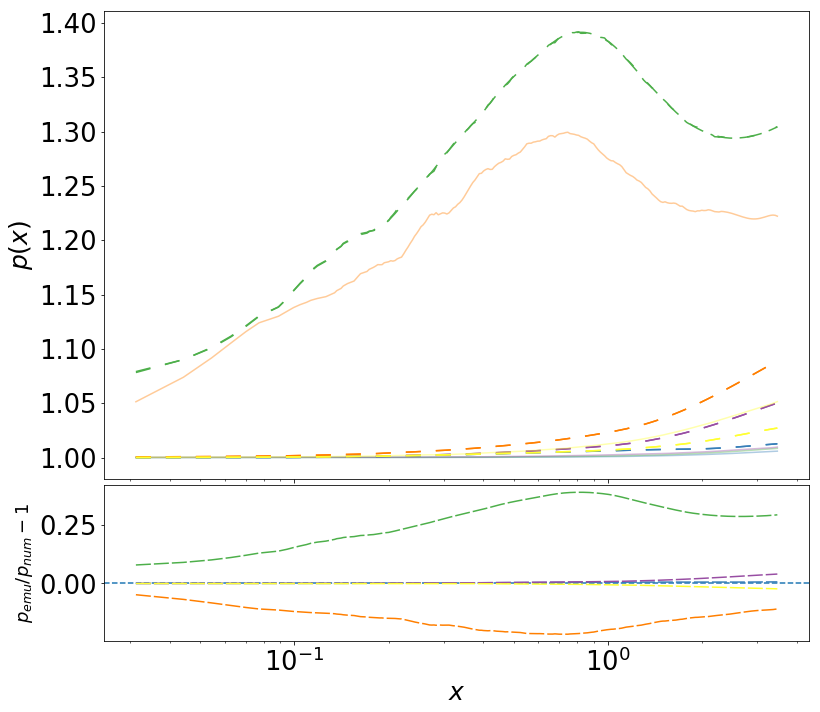

In [10]:
#### GP POSTERIOR DRAWS and PCA RECONSTRUCTIONS ######

# m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model_rank' +str(nRankMax)+ '.zip')
# pca_model = pickle.load(open(modelDir + 'PCA_model_rank'+str(nRankMax), 'rb'))

# m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model'+ str(nRankMax) +'.zip')
# m1 = GPy.models.GPRegression.load_model(GPmodel + '.zip')

ctx_for_loading = gpflow.saver.SaverContext(autocompile=False)
saver = gpflow.saver.Saver()

m1 = saver.load(GPmodel + str(nRankMax), context=ctx_for_loading)
m1.clear()
m1.compile()

pca_model = pickle.load(open(PCAmodel, 'rb'))

# plt.rc('text', usetex=True)  # Slower
plt.rc('font', size=18)  # 18 usually

plt.figure(999, figsize=(14, 12))
from matplotlib import gridspec

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs.update(hspace=0.02, left=0.2, bottom=0.15)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.set_ylabel(r'$p(x)$', fontsize=25)
ax1.set_xlabel(r'$x$', fontsize=25)
ax1.set_ylabel(r'$p_{emu}/p_{num} - 1$', fontsize = 18)
# ax1.set_ylim(-5e-2, 5e-2)

ax0.set_xscale('log')
# ax0.set_yscale('log')
ax1.set_xscale('log')

ax1.axhline(y=0, ls='dashed')

color_id = 0
for x_id in del_idx:
    color_id = color_id + 1
    time0 = time.time()
#     x_decoded_new = Emu(parameter_array_all[x_id], PCAmodel='PCA_model', GPmodel='GPy_model')
    x_decoded_new = Emu(parameter_array_unscaled[x_id])
    x_decoded_smooth = scipy.signal.savgol_filter(x_decoded_new , 51, 6)

    time1 = time.time()
    print('Time per emulation %0.5f' % (time1 - time0), ' s')
    ax0.plot(kvals, x_decoded_new, alpha=1.0, lw = 1.5, ls='--', label='emu', dashes=(10, 10), color=plt.cm.Set1(color_id))
    ax0.plot(kvals, x_decoded_smooth, alpha=1.0, lw = 1.5, ls='--', label='emu', dashes=(10, 10), color=plt.cm.Set1(color_id))

#     x_test = PmPl_all[x_id]
    x_test = scipy.signal.savgol_filter(PmPl_all[x_id], 51, 6)

    ax0.plot(kvals, x_test, alpha=0.4, label='real', color=plt.cm.Set1(color_id))

    ax1.plot(kvals, (x_decoded_smooth / (x_test) ) - 1, ls='--', dashes=(10, 2), color=plt.cm.Set1(color_id))


ax0.set_xticklabels([])
plt.savefig(plotsDir + 'Pemu_rank' +str(nRankMax) + '.png', figsize=(28, 24), bbox_inches="tight")
plt.show()

In [11]:
print(GPmodel)

./Models/Fixedn_val_latest/nCorrLogfixedGP_smooth_rank32snap97


Time per emulation 0.051  s
Time per emulation 0.023  s
Time per emulation 0.009  s
Time per emulation 0.018  s


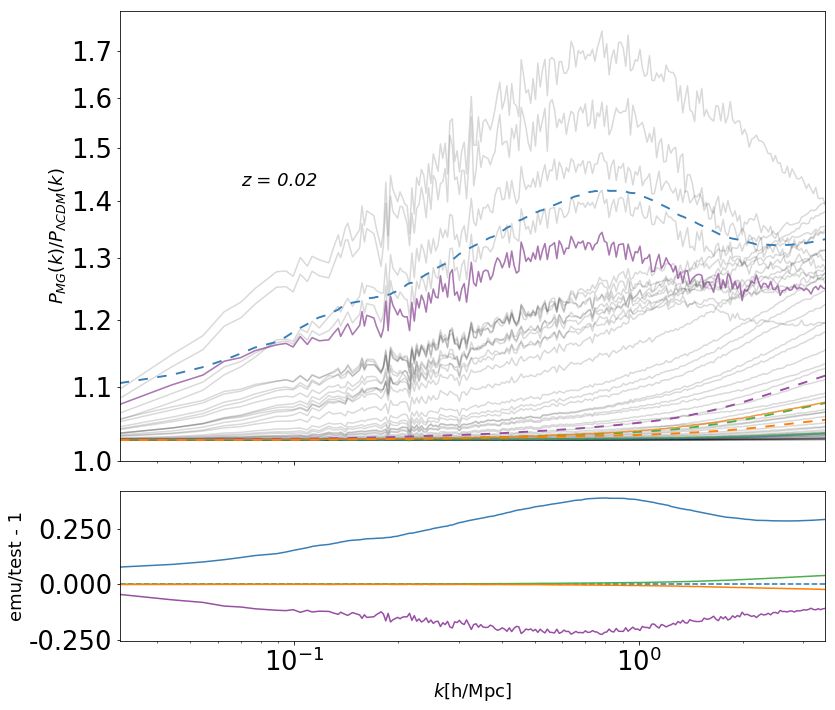

In [12]:
##################################### TESTING ##################################
plt.rc('font', size=18)  # 

PlotPrior = True

if PlotPrior:

    plt.figure(999, figsize=(14, 12))

    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    gs.update(hspace=0.1, left=0.2, bottom=0.15, wspace=0.25)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.set_ylabel(r'$P_{MG}(k)/P_{{\Lambda}CDM}(k)$',  fontsize = 18)

    ax1.set_xlabel(r'$k$[h/Mpc]',  fontsize = 18)
    ax1.axhline(y=0, ls='dashed')


    ax0.set_yscale('log')
    ax0.set_xscale('log')
    ax1.set_xscale('log')

    ax1.set_ylabel(r'emu/test - 1',  fontsize = 18)
    # ax1.set_ylim(-5e-2, 5e-2)

    ax0.plot(kvals, PmPl_all.T, alpha=0.15, color='k')

    start, end = ax0.get_ylim()
    ax0.yaxis.set_ticks((np.arange(start, end, 0.1)))
    ax0.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))


    ax0.set_xlim(kvals[0], kvals[-1])
    ax1.set_xlim(kvals[0], kvals[-1])
    ax0.set_xticklabels([])


    color_id = 0
    for x_id in del_idx[1:]:
        color_id = color_id + 1

        time0 = time.time()
        x_decodedGPy = Emu(parameter_array_unscaled[x_id])  ## input parameters
        time1 = time.time()
        print('Time per emulation %0.3f' % (time1 - time0), ' s')
        x_test = PmPl_all[x_id]

        ax0.plot(kvals, x_decodedGPy, alpha=1.0, ls='--', lw = 1.9, dashes=(5, 5), label='emu', color=plt.cm.Set1(color_id))
        ax0.plot(kvals, x_test, alpha=0.7, label='test', color=plt.cm.Set1(color_id))

        ax1.plot( kvals, (x_decodedGPy[:]) / (x_test[:])  - 1, color=plt.cm.Set1(color_id))

ax0.text(0.07, 1.4, 'z = %0.2f'%z_ID, fontsize= 18, style='italic')

plt.savefig(plotsDir + "Emu.png",  bbox_inches="tight", dpi=200)

plt.show()

In [13]:
x_decodedGPy.shape

(213,)

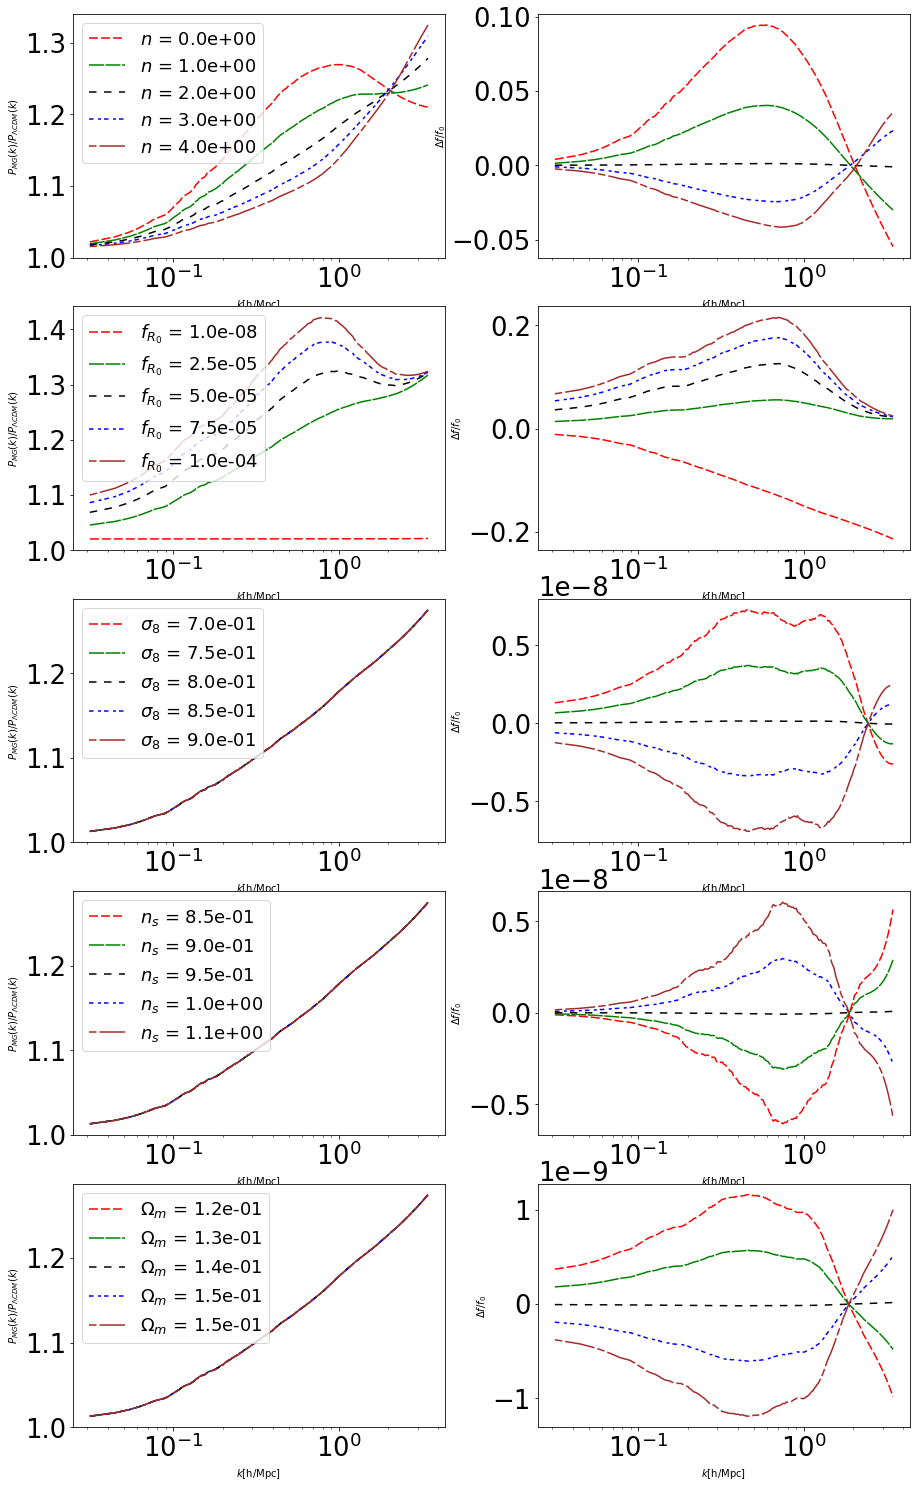

In [14]:
PlotCls = True

if PlotCls:
    
    numPlots = 5

    fig, ax = plt.subplots(5,2, figsize = (15,26))
    plt.subplots_adjust(wspace=0.25)
    
    allMax = np.max(parameter_array_unscaled, axis = 0)
    allMin = np.min(parameter_array_unscaled, axis = 0)
    allMean = np.mean(parameter_array_unscaled, axis = 0)
    Pk_mean = Emu(allMean) 
    
    for paramNo in range(5):
        para_range = np.linspace(allMin[paramNo], allMax[paramNo], numPlots)

        lines = ["-","-.","--",":"]
        linecycler = cycle(lines)
        dashList = [(6,2),(10,1),(5,5),(3,3,2,2),(5,2,20,2)]
        colorList = ['r', 'g', 'k', 'b', 'brown']


        for plotID in range(numPlots):
            para_plot = np.copy(allMean)
            para_plot[paramNo] = para_range[plotID]  
            x_decodedGPy = Emu(para_plot) 
            lineObj = ax[4-paramNo,0].plot(kvals, x_decodedGPy, lw= 1.5, linestyle='--', dashes=dashList[plotID], color = colorList[plotID], label = allLabels[paramNo] + ' = %.1e'%para_range[plotID])

            ax[4-paramNo,0].set_xscale('log')
            ax[4-paramNo,0].set_ylabel(r'$P_{MG}(k)/P_{{\Lambda}CDM}(k)$')
            ax[4-paramNo,0].set_xlabel('$k$[h/Mpc]')
            
            ax[4-paramNo,0].set_yticks([], minor = True)
            ax[4-paramNo,0].legend(iter(lineObj), para_range.round(decimals=2), title = allLabels[paramNo])
            ax[4-paramNo,0].legend()

            ax[4-paramNo,1].set_xscale('log')
            ax[4-paramNo,1].set_ylabel(r'$\Delta f / f_0$')
            ax[4-paramNo,1].set_xlabel('$k$[h/Mpc]')

            ax[4-paramNo,1].plot(kvals, (x_decodedGPy)/(Pk_mean) - 1, lw= 1.5, linestyle='--', dashes=dashList[plotID], color = colorList[plotID], label = para_range[plotID] )


        start, end = ax[4-paramNo, 0].get_ylim()
        ax[4-paramNo, 0].yaxis.set_ticks( (np.arange(start, end, 0.1)))
        ax[4-paramNo, 0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))


fig.savefig(plotsDir + "sensitivity.png",  bbox_inches="tight", dpi=200)

plt.show()

In [15]:

#################################################################################################
#################################################################################################
############################################## MCMC #############################################
#################################################################################################

import emcee
import pygtc

#### parameters that define the MCMC

ndim = 2
nwalkers = 800 #600  # 500
nrun_burn = 50  # 50 # 50  # 300
nrun = 800 #700  # 300  # 700


In [16]:
#### FAKE DATA GENERATION #####


create_fake_fiducial = False

if create_fake_fiducial:
    dirDataIn = "./Data/FiducialData/"

    seed = 1
    np.random.seed(seed)

    Pk_ratio = np.loadtxt(dirDataIn + 'ratios213.txt')[:, 25].T
    Pk_ratio = (1 + np.random.rand()/100)*Pk_ratio
    np.savetxt(dirDataIn + 'fiducial_ratio213.txt', Pk_ratio)

    cov_mat = np.zeros(shape = (Pk_ratio.shape[0], Pk_ratio.shape[0]))

    for i in range(Pk_ratio.shape[0]):
        cov_mat[i, i] = (1 + kvals[i]**2)*(1 + np.random.rand())*np.sqrt(Pk_ratio[i])/8000

    np.savetxt(dirDataIn + 'fiducial_cov213.txt', cov_mat)

In [17]:
# #### INTERPOLATED COV MATRIX GENERATION #####


create_cov_interpolate = True

if create_cov_interpolate:
    
    ### We have cavariance matrix for 20 bins, convert that to 213
        
    dirDataIn20 = "./Data/FiducialData/FromSims/"
    Pk_ratio20 = np.loadtxt(dirDataIn20 + 'ratioavg_97.txt')
    cov_mat20 = np.loadtxt(dirDataIn20 + 'covariance_97.txt')


    from scipy import interpolate 

    dataDir20 = "./Data/Emulator_data/" ## Data folder
    fileIn20 = dataDir20 + 'ratios_' + str(snap_ID) + '.txt'


    loadFile20 = np.loadtxt(fileIn20)
    kvals20 = loadFile20[:,0]

    x = kvals20
    y = kvals20
    z = cov_mat20

    cov_mat_model = interpolate.interp2d(x, y, z, kind='cubic')

    xnew = kvals
    ynew = kvals

    cov_mat213 = cov_mat_model(xnew, ynew)
    
    cov_mat = cov_mat213
    

    Pk_ratio_model = interpolate.CubicSpline(kvals20, Pk_ratio20[:, 1])
    
    Pk_ratio213 = Pk_ratio_model(kvals)
    
    Pk_ratio = Pk_ratio213
    
    

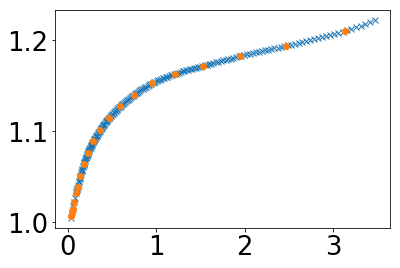

In [18]:
plt.figure(232)

plt.plot(kvals, Pk_ratio213, 'x')
plt.plot(kvals20, Pk_ratio20[:, 1], 'o')


plt.show()

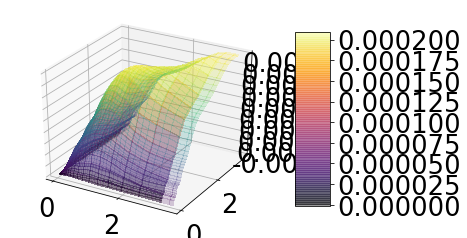

In [19]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

# %matplotlib notebook


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = kvals
Y = kvals
X, Y = np.meshgrid(X, Y)
Z = cov_mat

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis,
                       linewidth=0, antialiased=False, alpha = 0.2)



# Make data.
X = kvals20
Y = kvals20
X, Y = np.meshgrid(X, Y)
Z = cov_mat20

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.inferno,
                       linewidth=0, antialiased=False, alpha = 0.4)






# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.8, aspect=5)

plt.show()

In [20]:
########## REAL DATA with ERRORS #############################

# Pk_ratio = np.loadtxt(dirDataIn + 'fiducial_ratio213.txt')
# cov_mat = np.loadtxt(dirDataIn + 'fiducial_cov213.txt')

# dirDataIn = "./Data/FiducialData/FromSims/"
# Pk_ratio = np.loadtxt(dirDataIn + 'ratioavg_97.txt')
# cov_mat = np.loadtxt(dirDataIn + 'covariance_97.txt')

# kvals_max = 3.2
# kvals_cond = np.where(Pk_ratio < kvals_max)
kvals_cond = True

x = np.array(kvals)
y = Pk_ratio
yerr_diag = np.sqrt(np.diag(cov_mat))#[:, 0]



# x = x[kvals_cond]
# y = y[kvals_cond]

yerr_diag = yerr_diag[kvals_cond][0]
# emax = emax[ls_cond][:,ls_cond][:,0,:]
# cov_mat =  cov_mat[:len(kvals_cond[0]), :len(kvals_cond[0])]
## Only works if slicing is done at a corner.
# i.e., if ls_cond corresponds to continuous array entries in l
# icov = np.linalg.inv(cov_mat)


icov = np.linalg.pinv(cov_mat)

# Moore-Penrose pseudo-inverse of a matrix.



In [21]:
# Pk_ratio

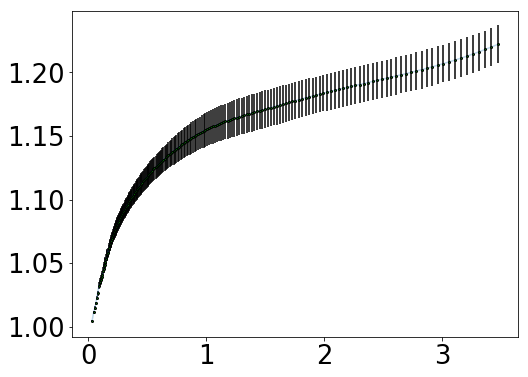

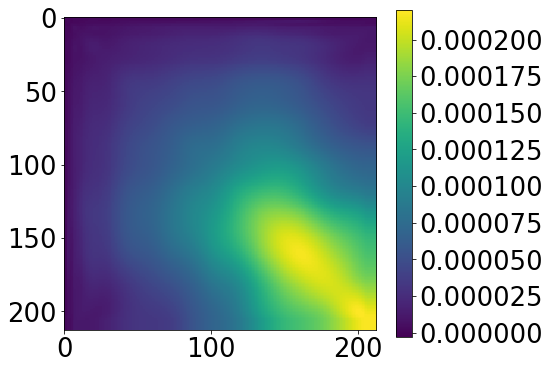

In [22]:
plt.figure(34, figsize = (8, 6))
# np.sqrt(yerr[::5])/Cl[::5]
plt.errorbar(x[::], y[::], yerr= yerr_diag[::] , marker='o',
       color='k',
       ecolor='k',
       markerfacecolor='g',
       markersize = 2,
       capsize=0,
       linestyle='None')


# plt.plot(kvals, np.loadtxt(dirDataIn + 'ratios213.txt')[:, 1:], alpha = 0.3)
plt.plot(kvals, Pk_ratio, alpha = 0.3)
# plt.xscale('log')
# plt.show()

plt.savefig('Plots/PowerSpect_emu.pdf')


plt.figure(43, figsize = (7, 6))
plt.imshow(cov_mat)
plt.colorbar()
# plt.show()

plt.savefig('Plots/Cov_mat.pdf')


In [23]:
y.shape

(213,)

In [24]:
kvals.shape

(213,)

In [25]:

# #### Cosmological Parameters ########################################

# parameter_array_all.min(axis=0)

# para1 = [allLabels[0], 0.1188, 0.12, 0.155]  # Actual 0.119
# para2 = [allLabels[1], 0.02230, 0.0215, 0.0235]
# para3 = [allLabels[2], 0.8159, 0.7, 0.89]
# para4 = [allLabels[3], 0.6774, 0.55, 0.85]
# para5 = [allLabels[4], 0.9667, 0.85, 1.05]


In [26]:

#### Cosmological Parameters ########################################

allMin = parameter_array_unscaled.min(axis=0)
allMax = parameter_array_unscaled.max(axis=0)
# allMean = parameter_array_all.mean(axis=0)
# allMean = parameter_array_all[25]

allMean = [0.141745, 0.9667, 0.8159, 1e-5, 1.0]


# Ω_m*h^2=0.141745, n_s=0.9667, σ_8 = 0.8159 and for the MG part f_r0=10^-5 and n=1

# para1 = [allLabels[0], allMean[0], allMin[0], allMax[0]]  # Actual 0.119
# para2 = [allLabels[1], allMean[1], allMin[1], allMax[1]]
# para3 = [allLabels[2], allMean[2], allMin[2], allMax[2]]
para4 = [allLabels[3], allMean[3], allMin[3], allMax[3]]
para5 = [allLabels[4], allMean[4], allMin[4], allMax[4]]


In [27]:
# kvals

In [28]:
p1, p2, p3, p4, p5 = allMean

In [29]:
if (para4[2] < p4 < para4[3] and para5[2] < p5 < para5[3]):
        print('Success')
print('fail')

Success
fail


In [30]:
def lnprior(theta):
    p4, p5 = theta
    # if 0.12 < p1 < 0.155 and 0.7 < p2 < 0.9:
    if (para4[2] < p4 < para4[3] and para5[2] < p5 < para5[3]):
        return 0.0
    return -np.inf


In [31]:
def lnprior_gauss(theta):
    p4, p5 = theta
    width = 2.0 #0.5
    #flat priors on b, c
#     if not 1.0 < b < 2.0 and 1.0 < c < 2.0:
    if not (para4[2] < p4 < para4[3] and para5[2] < p5 < para5[3]):
        return -np.inf
    #gaussian prior on a
    mu_para4 = para4[1]
    sigma_para4 = np.abs(para4[2] - para4[3])/2
#     lnprior1 =  np.log(1.0/(np.sqrt(2*np.pi)*sigma_para1))-0.5*(p1-mu_para1)**2/sigma_para1**2
    lnprior4 =  -width*(p4-mu_para4)**2/sigma_para4**2
    
        #gaussian prior on d
    mu_para5 = para5[1]
    sigma_para5 = np.abs(para5[2] - para5[3])/2
#     lnprior2 =  np.log(1.0/(np.sqrt(2*np.pi)*sigma_para2))-0.5*(p2-mu_para2)**2/sigma_para2**2
    lnprior5 =  -width*(p5-mu_para5)**2/sigma_para5**2
    
    return (lnprior4 + lnprior5)
    
    

In [32]:
lnprior([3e-5, 1.5])

0.0

In [33]:
# ######### TEMPLATE FOR MCMC LIKELIHOOD FUNCTION #######################
# # For emcee

# def lnlike(theta, x, y, icov):
#     p4, p5 = theta
    
#     new_params = np.array([allMean[0], allMean[1], allMean[2], p4, p5])

#     model = Emu(new_params)
    
#     y_model = np.asarray(y-model)
#     icov = np.asarray(icov)
#     return -0.5*(y_model.dot(icov).dot(y_model))

In [34]:
truncated_kvals = np.array(np.where(kvals < 1))
np.array(truncated_kvals)[0][-1]
truncated_kvals[0].shape

(134,)

In [35]:
## likelihood with reduced k-values

def lnlike(theta, x, y, icov):
    p4, p5 = theta
    
    kval_cut = 1.0
    truncated_kvals = np.where(x < kval_cut)
    
    new_params = np.array([allMean[0], allMean[1], allMean[2], p4, p5])

    icov = np.asarray(icov)
    
    
    model = Emu(new_params)
    
    model_red = model[truncated_kvals]
    icov_red = icov[0: np.array(truncated_kvals)[0][-1] + 1, 0: np.array(truncated_kvals)[0][-1] + 1]
    x_red = x[truncated_kvals]
    y_red = y[truncated_kvals]
    
    y_model = np.asarray(y_red-model_red)

    
    loglike = -0.5*(y_model.dot(icov_red).dot(y_model))
    return loglike

In [36]:



# def lnprob(theta, x, y, yerr):
#     lp = lnprior(theta)
#     if not np.isfinite(lp):
#         return -np.inf
#     # return lp + lnlike_diag(theta, x, y, yerr)
#     return lp + lnlike(theta, x, y, yerr)


def lnprob(theta, x, y, yerr):
    lp = lnprior_gauss(theta)
    # lp = lnprior(theta)
# 
    if not np.isfinite(lp):
        return -np.inf
    # return lp + lnlike_diag(theta, x, y, yerr)
    return lp + lnlike(theta, x, y, yerr)
############################# PARAMETERS ##############################

In [37]:
#################### CHAIN INITIALIZATION ##########################

## 2 options

Uniform_init = True
if Uniform_init:
    # Choice 1: chain uniformly distributed in the range of the parameters
    pos_min = np.array( [para4[2], para5[2]] )
    pos_max = np.array( [para4[3], para5[3]] )
    psize = pos_max - pos_min
    print(0.5*(pos_max - pos_min) )
    pos0 = [pos_min + psize * np.random.rand(ndim) for i in range(nwalkers)]

True_init = False
if True_init:
    # Choice 2: chain is initialized in a tight ball around the expected values
    pos1 = [[para1[1] * 1.2, para2[1] * 0.8, para3[1] * 0.9, para4[1] * 1.1, para5[1] * 1.2] +
            1e-3 * np.random.randn(ndim) for i in range(nwalkers)]

MaxLikelihood_init = False
if MaxLikelihood_init:
    # Choice 2b: Find expected values from max likelihood and use that for chain initialization
    # Requires likehood function below to run first

    import scipy.optimize as op

    nll = lambda *args: -lnlike(*args)
    result = op.minimize(nll, [para1[1], para2[1], para3[1], para4[1], para5[1]], args=(x, y, icov))
    p1_ml, p2_ml, p3_ml, p4_ml, p5_ml = result["x"]
    print(result['x'])

    pos0 = [result['x'] + 1e-2 * np.random.randn(ndim) for i in range(nwalkers)]


[4.9995e-05 2.0000e+00]


In [38]:

######### MCMC #######################


## Sample implementation :
# http://eso-python.github.io/ESOPythonTutorials/ESOPythonDemoDay8_MCMC_with_emcee.html
# https://users.obs.carnegiescience.edu/cburns/ipynbs/Emcee.html


# Let us setup the emcee Ensemble Sampler
# It is very simple: just one, self-explanatory line

# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr_diag))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, icov))

###### BURIN-IN #################

time0 = time.time()
# burnin phase
pos, prob, state = sampler.run_mcmc(pos0, nrun_burn)
sampler.reset()
time1 = time.time()
print('burn-in time:', time1 - time0)

burn-in time: 211.020179271698


In [39]:


###### MCMC ##################
time0 = time.time()
# perform MCMC
pos, prob, state = sampler.run_mcmc(pos, nrun)
time1 = time.time()
print('mcmc time:', time1 - time0)


###########################################################################

mcmc time: 3653.9438672065735


In [40]:
samples = sampler.flatchain
samples.shape

# samples[:, 3] = np.log10(samples[:, 3])

# samples_plot = sampler.chain[:, :, :].reshape((-1, ndim))
sampler_chain = sampler.chain[:, :, :]#.reshape((-1, ndim))


In [41]:
sampler.flatchain

array([[8.13404121e-06, 1.35392153e+00],
       [8.70865020e-06, 1.40401271e+00],
       [8.86652736e-06, 1.43900652e+00],
       ...,
       [9.16152172e-06, 1.50214613e+00],
       [8.46615682e-06, 1.34629003e+00],
       [8.87067295e-06, 1.44543465e+00]])

In [42]:
sampler_chain[:, :, 0] = np.log10(sampler_chain[:, :, 0] )

In [43]:

###########################################################################


np.savetxt('Data/Chains/2paraReducedSamplerPCA_mcmc_ndim' + str(ndim) + '_nwalk' + str(nwalkers) + '_run' + str(
    nrun) + '.txt', sampler_chain.reshape((-1, ndim)))

####### FINAL PARAMETER ESTIMATES #######################################



In [44]:

samples_plot = np.loadtxt('Data/Chains/2paraReducedSamplerPCA_mcmc_ndim' + str(ndim) + '_nwalk' + str(
    nwalkers) + '_run' + str(nrun) + '.txt')

# samples = np.exp(samples)
p4_mcmc, p5_mcmc = map(lambda v: (v[1], v[2] - v[1], v[1] - v[0]) , zip(*np.percentile(samples_plot, [16, 50, 84], axis=0)))
print('mcmc results:', p4_mcmc[0], p5_mcmc[0])
print('truth values:', np.log10(para4[1]), para5[1])
print(allMean)

mcmc results: -5.05662926784934 1.4396215802769774
truth values: -5.0 1.0
[0.141745, 0.9667, 0.8159, 1e-05, 1.0]


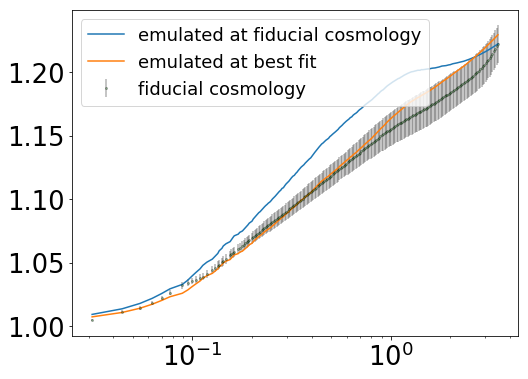

In [45]:
pfits = np.array([allMean[0], allMean[1], allMean[2], 10**(p4_mcmc[0]), p5_mcmc[0]])
fid_cosmo = np.array(allMean)

plt.figure(3111, figsize = (8, 6))
# np.sqrt(yerr[::5])/Cl[::5]
plt.errorbar(x[::], y[::], yerr= yerr_diag[::] , marker='o',
       color='k',
       ecolor='k',
       markerfacecolor='g',
       markersize = 2,
       capsize=0,
       linestyle='None', alpha = 0.3, label = 'fiducial cosmology')

plt.plot(x[::], Emu(fid_cosmo), label = 'emulated at fiducial cosmology')
plt.plot(x[::], Emu(pfits), label = 'emulated at best fit')

plt.xscale('log')
plt.legend()
plt.show()

In [46]:
allMean

[0.141745, 0.9667, 0.8159, 1e-05, 1.0]

In [47]:
samples_plot[:,:2].shape

(640000, 2)

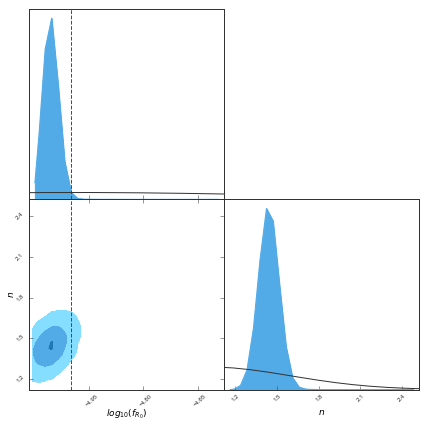

In [70]:
####### CORNER PLOT ESTIMATES #######################################

CornerPlot = True
if CornerPlot:

    width = 0.15
    
    priors = ((np.log10(para4[1]), width*np.abs( np.log10(para4[2]) - np.log10(para4[3]))),
          (para5[1], width*np.abs(para5[2] - para5[3])))

    fig = pygtc.plotGTC(samples_plot,
                        paramNames=[r'$log_{10}($'+para4[0] + r'$)$', para5[0]],
                        truths=[np.log10(para4[1]), para5[1]],
                        figureSize='MNRAS_page', nContourLevels=3, priors=priors)   # , plotDensity = True, filledPlots = False,\smoothingKernel = 0, nContourLevels=3)

    fig.savefig('Plots/pygtcPCA_' + str(ndim) + '_nwalk' + str(nwalkers) + '_run' + str(
        nrun) +  '.pdf')

####### FINAL PARAMETER ESTIMATES #######################################



In [ ]:
# import numpy
# lnlike([0.1, 1.1, 0.8, 3e-5, 1.5], x, y, yerr_diag)

In [ ]:
lnprior([3e-5, 1.5])

In [ ]:
pos0[0]

In [ ]:
[para4[2], para5[2]]


In [ ]:
samplerlnprob = (sampler.lnprobability)


In [ ]:
plt.figure(2323, figsize = (10,10))
plt.plot(samplerlnprob.T)
plt.yscale('symlog')
plt.show()

In [ ]:
plt.figure(23)
# plt.hist(samplerlnprob[:, -1], 10, alpha = 0.2)
plt.hist(samplerlnprob[:, -1][samplerlnprob[:, -1] > -150], 20, alpha = 0.4)
plt.hist(samplerlnprob[:, -1][samplerlnprob[:, -1] > -200], 10, alpha = 0.4)

In [ ]:
sampler.chain.shape

In [ ]:
####### CORNER PLOT ESTIMATES #######################################

new_samples = (sampler.chain[samplerlnprob[:, -1] > -200][:, :, :]).reshape((-1, ndim))


CornerPlot = True
if CornerPlot:

    fig = pygtc.plotGTC(new_samples,
                        paramNames=[r'$log_{10}($'+para4[0] + r'$)$', para5[0]],
                        truths=[np.log10(para4[1]), para5[1]],
                        figureSize='MNRAS_page', nContourLevels = 3, priors=priors) # , plotDensity = True, filledPlots = True,smoothingKernel = 0, nContourLevels= 3)

    fig.savefig('Plots/pygtcPCA_' + str(ndim) + '_nwalk' + str(nwalkers) + '_run' + str(
        nrun) +  '.pdf')

####### FINAL PARAMETER ESTIMATES #######################################

p4_mcmc, p5_mcmc = map(lambda v: (v[1], v[2] - v[1], v[1] - v[0]) , zip(*np.percentile(new_samples, [16, 50, 84], axis=0)))
print('mcmc results:', p4_mcmc[0], p5_mcmc[0])

p4_mcmc, p5_mcmc = map(lambda v: (v[1], v[2] - v[1], v[1] - v[0]) , zip(*np.percentile(samples_plot, [16, 50, 84], axis=0)))
print('mcmc results:', p4_mcmc[0], p5_mcmc[0])

In [ ]:
samplerlnprob[:, -1].shape

In [ ]:
# tau = sampler.get_autocorr_time()
# autocorr[index] = np.mean(tau)

In [ ]:
import matplotlib.pyplot as plt

n = 100*np.arange(1, index+1)
y = autocorr[:index]
plt.plot(n, n / 100.0, "--k")
plt.plot(n, y)
plt.xlim(0, n.max())
plt.ylim(0, y.max() + 0.1*(y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$");

In [ ]:
# Compute the estimators for a few different chain lengths
chain = sampler.chain#[:, :, 0].T


N = np.exp(np.linspace(np.log(100), np.log(chain.shape[1]), 10)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(chain[:, :n])
    new[i] = autocorr_new(chain[:, :n])

# Plot the comparisons
plt.loglog(N, gw2010, "o-", label="G\&W 2010")
plt.loglog(N, new, "o-", label="new")
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);